## Introduction

## Inspiration
[Music maps](https://www.music-map.com/) are incredibly cool and very useful for discovering new music within a certain genre, and we have been wanting to do something involving music and ML for a long time - that's why we decided to go with music for our overall theme. We were partially inspired by [The Language of Hip-Hop](https://pudding.cool/2017/09/hip-hop-words/), a project that visualizes hip-hop vocabulary and rappers along with it. We thought - why not try classifying music based on the audio as well? Sometimes lyrically sad songs don't have that sad timbre, and especially within rap where the lyrical elements overlap, adding in audio analysis could be really helpful. 

## Our motivation
The hip-hop genre has a bad rep amongst almost everyone except teenagers and young adults. It’s seen by many as disrespectful, void of musicality, or generally lacking positivity. Overall, it is generally just pushed to the side and trivialized to a single genre (be that “rap” or “hip-hop” or any other name). However, hip-hop music has been a part of our lives for a long time, and we argue that it’s actually quite diverse - we listen to different rap songs during different occasions, and for different purposes. 

Spotify has been very good, recently, at embracing up-and-coming hip-hop artists and making it accessible to more people by creating playlists for different moods. We’ve found, however, that many of these playlists aren’t very good at actually choosing the right songs for a specific time and place. Many playlists created for relaxing, for example, contain some songs that are a little too upbeat. Others, like those created for a night out, contain some songs that are a little too hardcore and not musical enough. This is understandable, as people tend to have different tastes and preferences. We wondered if using a machine to categorize songs into certain moods would classify songs more accurately than human choice.

## Our goal
We want to classify each song into one of four categories: ‘Party’, ‘Gym’, ‘Chill’ and ‘Sad’, for nights out, workout motivation, relaxing/studying and sorrow, respectively. To do so, we’ll use the [audio metadata](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/) that Spotify provides for each song. We’ll sort and visualize the data, determine what metadata is most useful in classifying tracks accurately, and train a machine learning model on these features. 


### Imports
A brief overview of the modules we used:
* [spotipy](https://spotipy.readthedocs.io/en/latest/), a module that allows us to work with the Spotify api in a more pythonic way
* [pandas](https://pandas.pydata.org/) and [numpy](http://www.numpy.org/) to organize our data
* [matplotlib](https://matplotlib.org/) and [seaborn](https://seaborn.pydata.org/) to visualize our data
* [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) to create models and make predictions 
* [graphviz](https://pypi.org/project/graphviz/) and [pydotplus](https://pydotplus.readthedocs.io/) to visualize our decision tree model

In [47]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
import seaborn as sb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree, ensemble, neighbors, model_selection, metrics
import graphviz
import pydotplus


# Data collection & processing

## Creating playlists
Let’s create four playlists with appropriate tracks for each of our “moods”. In doing so, we want to ensure that each song undisputedly belongs in said playlist. This is challenging because within the rap genre, there are many songs that could be classified as both gym and party songs. We want to find songs that are unambiguous - gym songs, for example have minimal melodic elements and are generally more aggressive. Party songs, however, have a rhythmic element and perhaps a chorus that is slightly more musical. Chill songs have a relaxed beat and less talking, while sad songs have minimal beats and more acoustic elements. We’ll have to play it by ear and use our pre-existing knowledge of rap music as well as our ability to classify by listening to create these lists.


## What data do we want?
In the Spotify database, all elements, such as playlists and individual songs, are identified by a unique ID, called a uri. The [spotipy module](https://spotipy.readthedocs.io/en/latest/) hooks into the Spotify API to obtain information and metadata for songs, playlists, albums using this uri. We’ll be using spotipy for the entirety of this tutorial, as it’s a convenient tool that makes API requests more “pythonic” in nature.

## About the audio metadata
Each song comes with metadata, and the metadata we’re interested in are the eight “features” that Spotify has assigned to each song - acousticness, danceability, energy, instrumentalness, liveness, loudness, speechiness, valence, and tempo. Each of these are float values that are defined as follows:
* **Acousticness**: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic. A song that is acoustic does not have any electrical amplification or elements.
* **Danceability**: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
* **Energy**: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
* **Instrumentalness**: Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0. 
* **Liveness**: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live. 
* **Loudness**: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Values typical range between -60 and 0 db. 
* **Speechiness**: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks. 
* **Valence**: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).  
* **Tempo**: The overall estimated tempo of a track in beats per minute (BPM). 

Straight away, we decided that we won’t be considering liveness as a feature, since none of the tracks that we’re analyzing are performed live.

### Spotify authorization

In [48]:
sb.set()

sp = spotipy.Spotify()
        
cid = "34f843c5f22c4242a2647ec4651ba2ce"
csec = "0826e491d90f4e43bbaec2fee7534610"


client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=csec)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

user_id = "1279914484"

# Data processing
## Defining necessary functions
Now that we’ve created our playlists on Spotify, let’s put them into a dataframe for easier visualization. We want to include features like song name, artists and uri, as well as the audio features we can get from the spotipy api. We’ll contain this code in two functions, so that we can reuse them as needed - one will create a dataframe from an existing Spotify playlist, one will create a dataframe from a manually passed-in list of uris. 


In [63]:
attributes = ["danceability","energy", "loudness", "speechiness", "acousticness", "instrumentalness", "valence", "tempo"]

def df_from_playlist(uri,song_type=None, user=user_id):
    p1 = sp.user_playlist(user=user, playlist_id=uri)

    p1_dict = {"name":[], "uri":[], "artists":[]}
    
    if song_type:
        p1_dict['type'] = []

    for song in p1['tracks']['items']:
        if not song['track']: continue
        name = song['track']['name']
        uri = song['track']['uri'].split(":")[2]
        a = song['track']['artists']
        artists = []
        for ar in a:
            artists.append(ar['name'])
        anal = sp.audio_features(uri)[0]

        wanted_keys = ["danceability","energy", "loudness", "speechiness", "acousticness", "instrumentalness", "valence", "tempo"]
        sub = dict((k, anal[k]) for k in wanted_keys if k in anal)

        p1_dict['name'] += [name]
        p1_dict['uri'] +=  [uri]
        p1_dict['artists'] +=  [str(artists)[1:-1]]
        if song_type:
            p1_dict['type'] += [song_type]

        for k in wanted_keys:
            if k in p1_dict:
                p1_dict[k] += [sub[k]]
            else:
                p1_dict[k] = [sub[k]]
    return pd.DataFrame.from_dict(p1_dict)

def df_from_uri(uri_list, song_type):
    s_dict = {'name':[], 'type': [], 'uri': []}
    for uri in uri_list:
        name = sp.track(uri)['name']
        anal = sp.audio_features(uri)[0]

        wanted_keys = ["danceability","energy", "loudness", "speechiness", "acousticness", "instrumentalness", "valence", "tempo"]
        sub = dict((k, anal[k]) for k in wanted_keys if k in anal)

        s_dict['name'] += [name]
        s_dict['uri'] +=  [uri]
        s_dict['type'] += [song_type]
        for k in wanted_keys:
            if k in s_dict:
                s_dict[k] += [sub[k]]
            else:
                s_dict[k] = [sub[k]]
    return pd.DataFrame.from_dict(s_dict)
      

In [50]:
# Come & See Me, Love n Hennessy, Neighbors, A Place Like This
chill_uris = ['1wZqJM5FGDEl3FjHDxDyQd','57zEbGuOa9Skogmm0WdOzM','0utlOiJy2weVl9WTkcEWHy','1jRHh8JcdUV9zTiAmyzhU9']

# Shot Down, Fly Away, Save Me, Same Drugs
sad_uris = ['58nciIyr5vKpUJkUXXkxCq','0f1odHdnTJyxrLI4nWfSs6','2UwbhMie1EAYuTZ0QXeMwl','6m9qPYXmhge2QhBLfFKnVF']

# Look At Me!, New Level, Old English, Check
gym_uris = ["7floNISpH8VF4z4459Qo18", "11BIoKDpTJHX5mZt6p566h", "56X1fzloIoGKKOgpLLIGoe", "5vZDl7Jr6GmtJjnziKSBqN"]

# Motorsport, Pills & Automobiles, Unforgettable, Nice For What
party_uris = ["4wFjTWCunQFKtukqrNijEt", "4YkwUfWSIxdKNLDXw0caFO", "3B54sVLJ402zGa6Xm4YGNe", "3CA9pLiwRIGtUBiMjbZmRw"]
    
party = df_from_uri(party_uris, "Party")
chill = df_from_uri(chill_uris, "Chill")
sad = df_from_uri(sad_uris, "Sad")
gym = df_from_uri(gym_uris, "Gym")

all_lists = pd.concat([party, chill, sad, gym])
display(all_lists)


,name,type,uri,danceability,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo
0,MotorSport,Party,4wFjTWCunQFKtukqrNijEt,0.896,0.515,-5.395,0.1830,0.033800,0.000000,0.1740,138.016
1,Pills & Automobiles,Party,4YkwUfWSIxdKNLDXw0caFO,0.820,0.696,-4.918,0.1820,0.119000,0.000000,0.6170,144.981
2,Unforgettable,Party,3B54sVLJ402zGa6Xm4YGNe,0.726,0.769,-5.043,0.1230,0.029300,0.010100,0.7330,97.985
3,Nice For What,Party,3CA9pLiwRIGtUBiMjbZmRw,0.586,0.909,-6.474,0.0705,0.089100,0.000109,0.7570,93.394
0,Come and See Me (feat. Drake),Chill,1wZqJM5FGDEl3FjHDxDyQd,0.717,0.347,-10.265,0.0636,0.051100,0.000002,0.0589,84.987
1,Love N Hennessy,Chill,57zEbGuOa9Skogmm0WdOzM,0.931,0.306,-9.979,0.4530,0.012800,0.000009,0.4570,140.039
2,Neighbors,Chill,0utlOiJy2weVl9WTkcEWHy,0.894,0.284,-13.002,0.3300,0.358000,0.000487,0.4130,138.944
3,A Place Like This,Chill,1jRHh8JcdUV9zTiAmyzhU9,0.551,0.449,-11.297,0.0637,0.044200,0.006810,0.3920,133.558
0,Shot Down,Sad,58nciIyr5vKpUJkUXXkxCq,0.769,0.511,-6.673,0.0609,0.885000,0.000186,0.5070,123.954
1,Fly Away,Sad,0f1odHdnTJyxrLI4nWfSs6,0.707,0.256,-13.872,0.0397,0.039900,0.156000,0.0652,89.990


# Exploratory analysis & data visualization
## Plotting our data
Now that we have dataframes with the information we need, we can plot all of it on a bar graph. 
By visualizing the audio features, we can get a feel for the data and also start to think about how to train a machine learning model using the features of each song.

Using matplotlibs bar method, we plotted each attribute for each song. Each feature gets its own plot so that plots are easier to analyze. The different colors on each plot represent a different playlist, as laid out in the legend, and the horizontal bar across each color represents the average value of that attribute for the respective playlist. We’ve taken out the names of the songs on the x-axis, because they’re not necessary to our understanding of the plot and doing so makes the visualization cleaner. 

The purpose of our visualization is to determine which features differ across playlists so that we can use them as training features for our machine learning model. 

<Figure size 5040x5040 with 0 Axes>

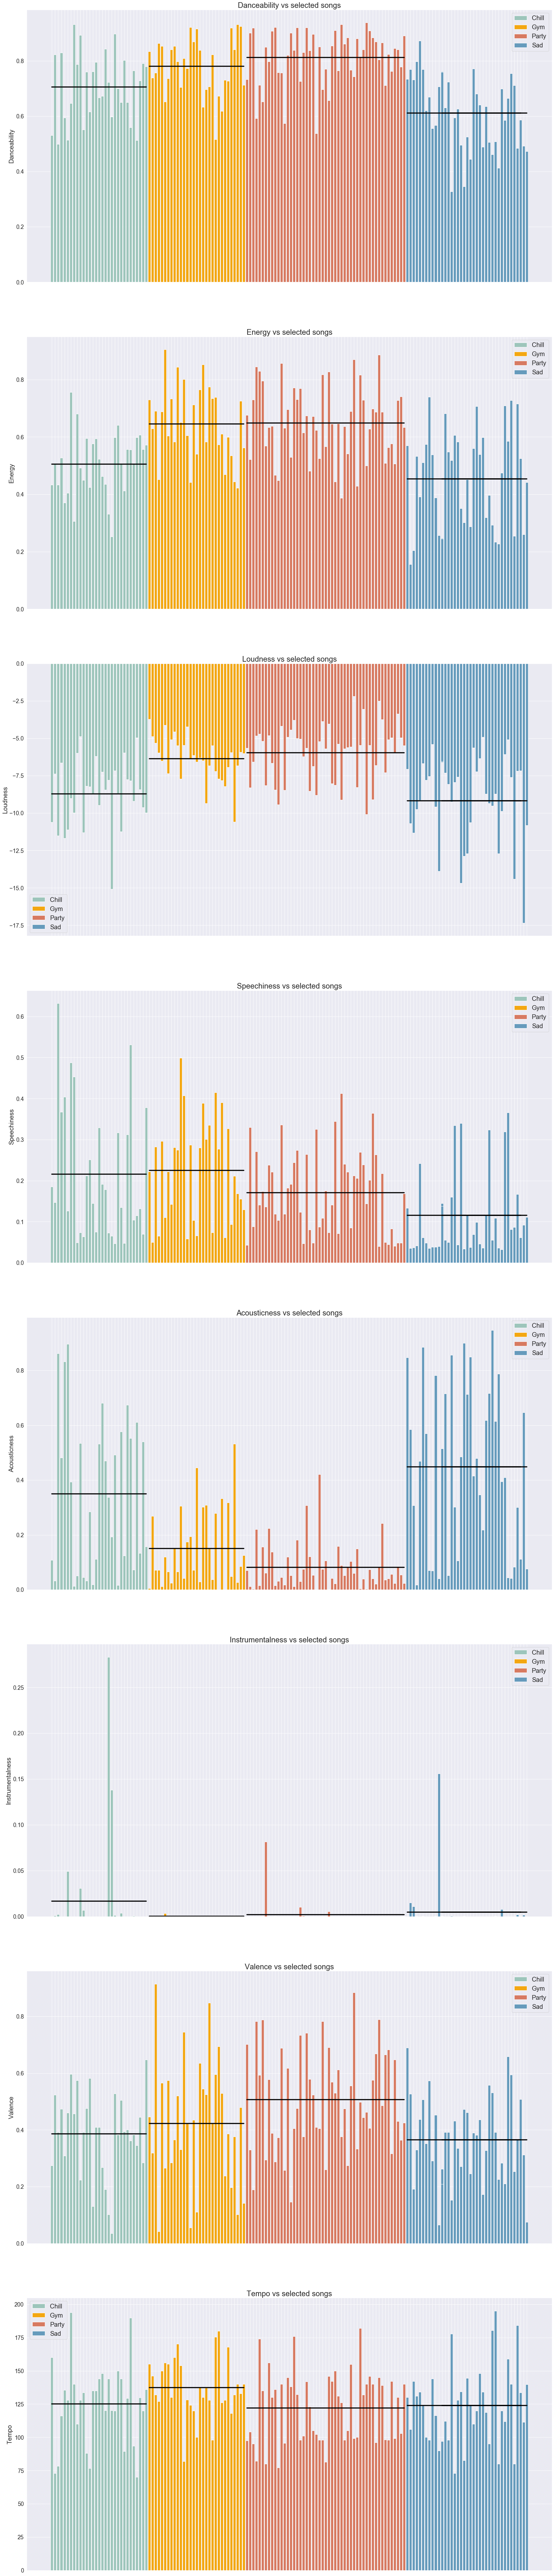

In [51]:
plt.figure(figsize=(70,70))
#a = (a1,a2,a3,a4,a5,a6,a7,a8)
f,a = plt.subplots(len(attributes),1,figsize=(30,150))
colors = {'Chill':'#9DC5BB', 'Gym':'#F3A712', 'Party':'#D77A61', 'Sad':'#669BBC'}


sad_training = df_from_playlist('7GIMKQrjyYXlzkCnS99bzp',song_type='Sad',user='1279914484')
gym_training = df_from_playlist('6jEXwWSWPaGp3PaaEFVZg2',song_type='Gym',user='1279914484')
chill_training = df_from_playlist('7k4Y4X1BLH6vogZPQvXkd3',song_type='Chill',user='1279914484')
party_training = df_from_playlist('0FvUNf05XwDGmStECPUcjd',song_type='Party',user='1279914484')

training = pd.concat([sad_training,chill_training,party_training,gym_training])


i = 0
for ax in a:
    for key,df in training.groupby('type'):
        ax.bar(x=df['name'], height=df[attributes[i]], label=key, color=colors[key])
        
        mean = df[attributes[i]].mean()
        y = [mean for _ in range(len(df['name']))]
        ax.plot(df['name'], y, color='#000000', linewidth=3.5)
        
        ax.legend(fontsize=20)
        ax.set_title(attributes[i].capitalize() + ' vs selected songs', fontsize=24)
        ax.set_ylabel(attributes[i].capitalize(), fontsize=20)
        ax.set_xticklabels([])
        #for tick in ax.get_xticklabels():
            #tick.set_rotation(45)
            #tick.set_fontsize(18)
        for tick in ax.get_yticklabels():
            tick.set_fontsize(18)
    

    i+=1



plt.show()

##  Data analysis
The final four features were decided on were speechiness, energy, loudness, and acousticness. Here’s why:

* Speechiness, energy, loudness, and acousticness all had distinct averages amongst themselves.
* Danceability and tempo did not have these distinct averages, so we discarded them.
* Rap tracks are clearly vocal (as stated in the definition of instrumentalness), so the instrumentalness of a track is insignificant across rap music.
* Spotify defines valence across all genres  - which means that it’s being pooled in with songs that are generally more “positive,” like pop and country. While rap numerically has a lower valence than other songs in the Spotify database, due to the nature of its musical elements, within rap itself there is an identifiable gradient of negative to positive valence, which doesn’t necessarily line up with its numerical valence measurement, as is observed in our graph. As such, we decided not to use valence in our model.


# Hypothesis testing & machine learning
## Decision tree
Now, let’s try to classify our data. Our ultimate goal is to use the information we’ve collected about each song, and somehow determine what “mood” that song falls into.  

After looking at various classification methods, we decided that a decision tree was the best model for our data, and we used sklearn's [decision tree classifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) to fit our data. From our previous data analysis, we’ve decided that the best features to use are speechiness, energy, loudness, and acousticness. 

We trained the decision tree on our data by giving it the feature vectors for each of 120 songs and the class for each respective song. We then predicted the classes of 30 songs that did not overlap with our training data and put the predicted and expected values of each song into a Pandas dataframe.


In [52]:
features = ['speechiness', 'energy', 'loudness', 'acousticness']
classes = ['Chill', 'Gym', 'Party', 'Sad']

#display(training)
def get_ftr_array(uri):
    name = sp.track(uri)['name']
    anal = sp.audio_features(uri)[0]
    return np.array([anal[x] for x in features])


X = []
Y = []
test = df_from_playlist('3r4QivLAUexk9cqnI1zV2n',user='rayshruti')

#display(training)
for key, row in training.iterrows():
        X.append(row[features].values)
        Y.append(row['type'])

        
# Decision tree        
dt = tree.DecisionTreeClassifier()
dt.fit(X,Y)

# Random forests
#rf = ensemble.RandomForestClassifier(n_estimators=4)
#rf.fit(X,Y)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [54]:
def diff(cat1, cat2):
    return (cat1 in ['Gym','Party'] and cat2 in ['Sad','Chill']) or (cat2 in ['Gym','Party'] and cat1 in ['Sad','Chill'])

expected = ['Party', 'Party', 'Party', 'Party', 'Party', 'Party', 'Gym', 'Sad', 'Gym', 'Gym', 'Chill', 'Gym', 'Sad', 'Sad', 'Sad', 'Gym', 'Chill', 'Party', 'Party', 'Gym', 'Party', 'Chill', 'Chill', 'Party', 'Chill', 'Party', 'Chill', 'Party', 'Gym', 'Party', 'Party', 'Chill']
test['expected'] = expected
wrong = 0
for key,row in test.iterrows():
    f = get_ftr_array(row['uri']).reshape(1, len(features))
    test.at[key,'decision_tree'] = dt.predict(f)[0]
    if diff(row['decision_tree'],row['expected']):
        wrong += 1
    
def color_categories(val):
    if val == 'Party' or val == 'Sad' or val == 'Chill' or val == 'Gym': 
        color = colors[val]
    else: color = ''
    
    return 'background-color: %s' % color

print("wrongly classified: ", wrong)
df = test[['name', 'artists', 'decision_tree', 'expected']]
s = df.style.applymap(color_categories)
s


wrongly classified:  0


,name,artists,decision_tree,expected
0,Bodak Yellow,'Cardi B',Gym,Party
1,HUMBLE.,'Kendrick Lamar',Chill,Party
2,The Motto,"'Drake', 'Lil Wayne'",Party,Party
3,HYFR (Hell Ya Fucking Right),"'Drake', 'Lil Wayne'",Chill,Party
4,Calm Down,'G-Eazy',Party,Party
5,Bad Company,"'A$AP Rocky', 'BlocBoy JB'",Party,Party
6,RAF,"'A$AP Mob', 'A$AP Rocky', 'Playboi Carti', 'Quavo', 'Lil Uzi Vert', 'Frank Ocean'",Sad,Gym
7,Marvins Room,'Drake',Sad,Sad
8,Gunz N Butter,"'A$AP Rocky', 'Juicy J'",Chill,Gym
9,Angels,'A$AP Rocky',Sad,Gym


In [ ]:
t = tree.export_graphviz(dt, feature_names=features, class_names=classes, out_file=None)

graph=graphviz.Source(t)
graph

graph.render('tree', view=True)  

## Grid search cross-validation
There is no default maximum depth for a decision tree in sklearn. Having a decision tree that is too deep may result in overfitting of the data, which means that the tree would perform poorly when predicting on test data because it loses its generality. We used the GridSearchCV model to try and determine an ideal max_depth value and attempted to redefine and retrain our decision tree using this depth, but changing the max depth did not affect the classification of our test data.


In [ ]:
param_grid = {'max_depth': np.arange(3, 10)}

grid_search = model_selection.GridSearchCV(tree.DecisionTreeClassifier(random_state=0), param_grid, cv=model_selection.StratifiedKFold(shuffle=False))
grid_search.fit(X, Y)
print(grid_search.best_score_)
print(grid_search.best_params_)




In [ ]:
# Decision tree, max depth 5        
dt2 = tree.DecisionTreeClassifier(max_depth=5)
dt2.fit(X,Y)

In [66]:
wrong = 0
for key,row in test.iterrows():
    f = get_ftr_array(row['uri']).reshape(1, len(features))
    test.at[key,'decision_tree'] = dt2.predict(f)[0]
    if diff(row['decision_tree'],row['expected']):
        wrong += 1
print("wrongly classified: ", wrong)
df = test[['name', 'artists', 'decision_tree', 'expected']]
s = df.style.applymap(color_categories)
s

wrongly classified:  15


,name,artists,decision_tree,expected
0,Bodak Yellow,'Cardi B',Chill,Party
1,HUMBLE.,'Kendrick Lamar',Chill,Party
2,The Motto,"'Drake', 'Lil Wayne'",Party,Party
3,HYFR (Hell Ya Fucking Right),"'Drake', 'Lil Wayne'",Chill,Party
4,Calm Down,'G-Eazy',Party,Party
5,Bad Company,"'A$AP Rocky', 'BlocBoy JB'",Party,Party
6,RAF,"'A$AP Mob', 'A$AP Rocky', 'Playboi Carti', 'Quavo', 'Lil Uzi Vert', 'Frank Ocean'",Chill,Gym
7,Marvins Room,'Drake',Sad,Sad
8,Gunz N Butter,"'A$AP Rocky', 'Juicy J'",Chill,Gym
9,Angels,'A$AP Rocky',Sad,Gym


## Hypothesis testing
We decided that it would be fun to test our model against Spotify's officially curated hip-hop playlists, as we've often found that their playlists are sadly lacking in the actual moods they claim to cater to. We picked the most popular Spotify playlists that matched some of our defined moods:

* Gym: [**Beast Mode** by Spotify](https://open.spotify.com/user/spotify/playlist/37i9dQZF1DX76Wlfdnj7AP?si=woBb5x1QRuy7XpUflWNQLg)
* Party: [**Get Turnt** by Spotify](https://open.spotify.com/user/spotify/playlist/37i9dQZF1DWY4xHQp97fN6?si=659L0iKRTAG_x5udwLvbIw)
* Chill: [**Love, Sex and Water** by Spotify](https://open.spotify.com/user/spotify/playlist/37i9dQZF1DWX3387IZmjNa?si=JHYGZnFvSmC51P1f-G3C6A)

We hypothesize that for each of these curated playlists, our model will classify less than 60% of the songs in the playlist as the category that the playlist actually claims to be.

In [95]:
def graph_counts(test, explode, title):
    counts = [0,0,0,0]
    for key,row in test.iterrows():
        f = get_ftr_array(row['uri']).reshape(1, len(features))
        test.at[key,'decision_tree'] = dt.predict(f)[0]
        counts[classes.index(test.at[key, 'decision_tree'])] += 1
        
    df = test[['name', 'artists', 'decision_tree']]
    s = df.style.applymap(color_categories)
    s

    fig1, ax1 = plt.subplots()
    ax1.pie(counts, explode=explode, labels=classes, colors=colors.values(), autopct='%1.1f%%',
            shadow=False, startangle=90)
    ax1.axis('equal')
    ax1.set_title(title, fontsize=18)
    plt.tight_layout()
    plt.show()


In [96]:

beast_mode = df_from_playlist('37i9dQZF1DX76Wlfdnj7AP',user='spotify')
get_turnt = df_from_playlist('37i9dQZF1DWY4xHQp97fN6',user='spotify')
love_sw = df_from_playlist('37i9dQZF1DWX3387IZmjNa',user='spotify')


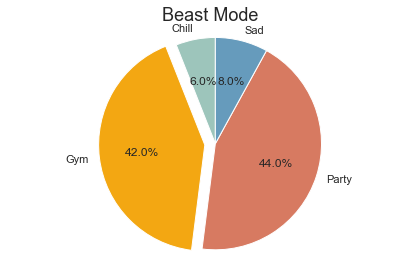

retrying ...1secs


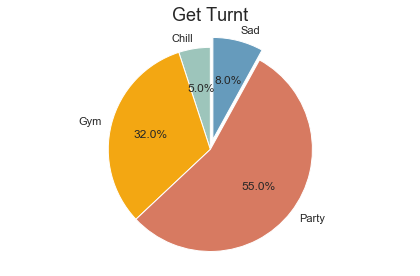

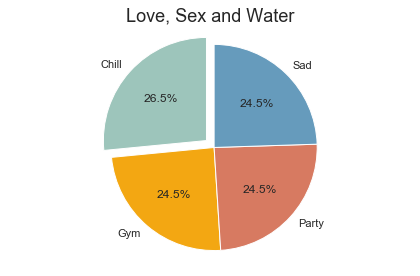

In [97]:
graph_counts(beast_mode, explode=(0, 0.1, 0, 0), title='Beast Mode')
graph_counts(get_turnt, explode=(0, 0, 0, 0.1), title='Get Turnt')
graph_counts(love_sw, explode=(0.1, 0, 0, 0), title='Love, Sex and Water')


Looks like our hypothesis was correct. Spotify's playlists aren't that great.... but what else is new? 


# Insight & policy decision
## Conclusion
* Since we are classifying training data ourselves, there is definite bias in our selection; therefore there are understandable disparities between our expectations and machine-predicted data 
* Individual rap songs do tend to fit several bills, so the “disparities” that we observe between our classification and the model’s predictions don’t mean that the model is entirely wrong. It’s actually pretty accurate, in the sense that it may classify a song as ‘Gym’  that we labeled ‘Party’, but that doesn’t mean we wouldn’t listen to it in the gym. Several songs in my party and gym playlists, in fact, overlap. That’s part of the beauty of rap - many songs are suited to different occasions. 
* One of the problems with trying to classify rap music is that the mood that it suits doesn’t always necessarily line up with its musical elements. One feature we think would definitely improve the accuracy of our model is adding some kind of weighted score that takes into account the valence of the song lyrics. We believe that combining this with the actual musical elements would produce a much more accurate classifier. 
* Can we apply our method of “classifying” songs to other genres that are more musically varied? In this case, we’d probably need to reconsider the features that we used. For example, certain renditions of rock songs are performed live, so we’d need to take that into consideration. 
